## Project 3

Store Analysis

In [ ]:
# Import Packages

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [ ]:
liquor = pd.read_csv('../../../Iowa_Liquor_Sales_reduced.csv') # Read in CSV

In [ ]:
liquor.shape # Determine shape of the matrix

In [ ]:
liquor = liquor.dropna(axis=0, how='any') # Drop any row that contains a NaN value

In [ ]:
liquor.shape # observe changed shape

## Exploratory Analysis

*Look to clean up data, and run initial tests*

In [12]:
columns = liquor.columns.values      # Pull columns

In [13]:
new_cols = []                        # Create new list for assignment
for column in columns:
    col = re.sub('\s+', '_', column) # Replace spaces with Underscores
    col = re.sub('[()]','',col)      # Replace paren with emptyspace
    new_cols.append(col)             # Add to columns list

In [14]:
liquor.columns = new_cols            # Assign Current Columns to New Name

In [15]:
liquor.head()                        # Look at head of the dataframe

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,9.99,14.99,12,179.88,4.50,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,12.50,18.75,2,37.50,2.00,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,5.97,8.96,6,53.76,10.50,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,2.24,3.36,48,161.28,9.60,2.54
5,03/31/2016,4988,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,260,17090,Bulleit Bourbon 10YR,750,23.00,34.50,1,34.50,0.75,0.20


In [16]:
dollar_columns = ['State_Bottle_Cost',      # Pull cols with dollar values
                  'State_Bottle_Retail', 
                  'Sale_Dollars']

liquor[dollar_columns] = \
liquor[dollar_columns].replace(             # Replace:
    '[\$,]',                                # Dollar signs with:
    "",regex=True                           # Empty Space and
).astype(float)                             # Assign to float

In [28]:
print liquor[liquor['County'] == np.NaN]

Empty DataFrame
Columns: [Date, Store_Number, City, Zip_Code, County_Number, County, Category, Category_Name, Vendor_Number, Item_Number, Item_Description, Bottle_Volume_ml, State_Bottle_Cost, State_Bottle_Retail, Bottles_Sold, Sale_Dollars, Volume_Sold_Liters, Volume_Sold_Gallons]
Index: []


In [13]:
liquor.dtypes # assess conversion

Date                    object
Store_Number             int64
City                    object
Zip_Code                object
County_Number          float64
County                  object
Category               float64
Category_Name           object
Vendor_Number            int64
Item_Number              int64
Item_Description        object
Bottle_Volume_ml         int64
State_Bottle_Cost      float64
State_Bottle_Retail    float64
Bottles_Sold             int64
Sale_Dollars           float64
Volume_Sold_Liters     float64
Volume_Sold_Gallons    float64
dtype: object

*Will be focusing on a County level of sales to determine what counties are worth focusing on. Because of that will be creating new dataframe that contains truncated list. 
Need to also turn date into a datetime object."

# Data Dictionary

|Name|Description|Variable Type|
|--|--|--|
|Date|Date The Transaction Took Place|Ordinal|
|Store_Number|Unique Numerical ID for Liquor Stores in Iowa|Ordinal|
|City|City Where Store is Based|Categorical|
|Zip_Code|Zip Code of Store Location|Ordinal|
|County_Number|The County's Number as Assigned by the State of Iowa|Ordinal|
|County|County Name|Categorical|
|Category|Unique Numerical ID for Category of Sale|Ordinal|
|Category_Name|Category of Alcohol Sold|Categorical|
|Vendor_Number|Unique Numerical ID assigned to Vendor|Ordinal|
|Item_Number|Unique Numerical ID of the Item Sold|Ordinal|
|Item_Description|Description of the Item Sold|Categorical
|Bottle_Volume_ml|Volume of the Bottle Sold|Interval|
|State_Bottle_Cost|Cost of Bottle|Interval|
|State_Bottle_Retail|Cost of Bottle at Retail|Interval|
|Bottles_Sold|Number of Bottles Sold in Transaction|Ordinal|
|Sale_Dollars|Total Price of Sale in Dollars|Interval|
|Volume_Sold_Liters|Volume of Alcohol Sold in Liters|Interval|
|Volume_Sold_Gallons|Volume of Alcohol Sold in Gallons|Interval|


In [ ]:
liquor['Date'] = pd.to_datetime(liquor['Date'])                   # Convert to DateTime

In [ ]:
liquor = liquor[['Date',                                          # Sale dates to split into 2015/2016
                 'County_Number','County',                        # County identifiers
                 'State_Bottle_Cost', 'State_Bottle_Retail',      # Costs of bottles sold
                 'Bottles_Sold', 'Volume_Sold_Liters',            # Measures of how much was sold
                 'Sale_Dollars'                                   # Amount of total sales
                ]]

# Modified Data Dictionary

|Name|Description|Variable Type|
|--|--|--|
|Date|Date The Transaction Took Place|Ordinal|
|County_Number|The County's Number as Assigned by the State of Iowa|Ordinal|
|County|County Name|Categorical|
|State_Bottle_Cost|Cost of Bottle|Interval|
|State_Bottle_Retail|Cost of Bottle at Retail|Interval|
|Bottles_Sold|Number of Bottles Sold in Transaction|Ordinal|
|Sale_Dollars|Total Price of Sale in Dollars|Interval|
|Volume_Sold_Liters|Volume of Alcohol Sold in Liters|Interval|

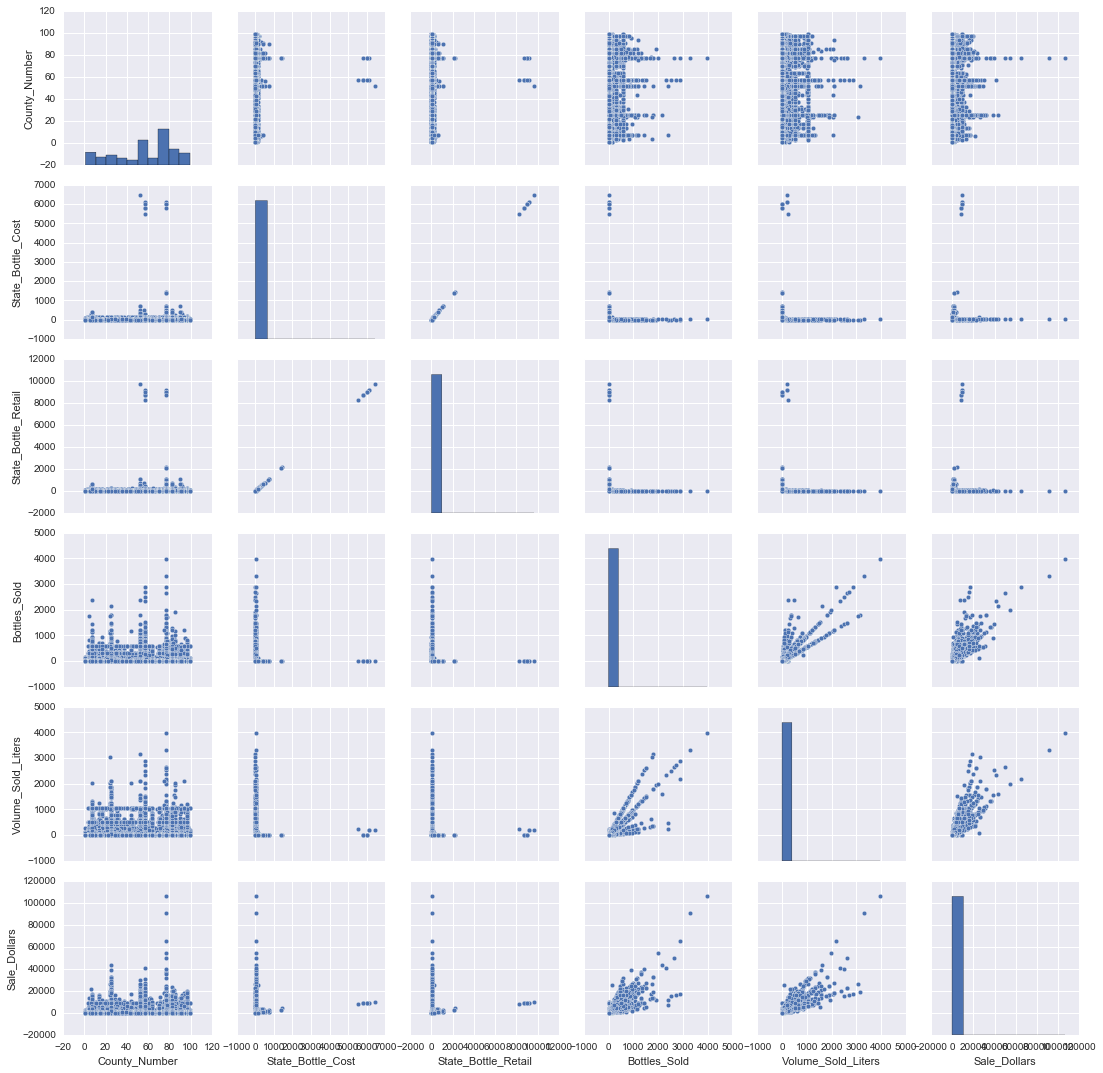

In [16]:
sns.pairplot(liquor)

In [ ]:
sale_Dollars = liquor[['County','Store_Number','Sale_Dollars']].groupby(['County','Store_Number']).sum()

In [ ]:
plt.figure(figsize=(10,10))

sns.distplot(sale_Dollars)

In [ ]:
# (liquor_test['Sale_Dollars'][liquor_test['Sale_Dollars'] < 15000]).sum()
(liquor['Sale_Dollars'][liquor['Sale_Dollars'] < 10000]).sum()

In [ ]:
(liquor['Sale_Dollars'][liquor['Sale_Dollars'] > 10000]).sum()

In [ ]:
x = 15000

while liquor['Sale_Dollars'] / liquor[]

In [ ]:
425627.6399999999/(425627.6399999999+16814733.250002645)

In [21]:
liquor['State_Bottle_Cost'].describe()

count    2.692602e+06
mean     9.803065e+00
std      1.493316e+01
min      8.900000e-01
25%      5.510000e+00
50%      8.000000e+00
75%      1.192000e+01
max      6.468000e+03
Name: State_Bottle_Cost, dtype: float64

In [20]:
liquor['State_Bottle_Retail'].describe()

count    2.692602e+06
mean     1.472047e+01
std      2.239944e+01
min      1.340000e+00
25%      8.270000e+00
50%      1.227000e+01
75%      1.788000e+01
max      9.702000e+03
Name: State_Bottle_Retail, dtype: float64

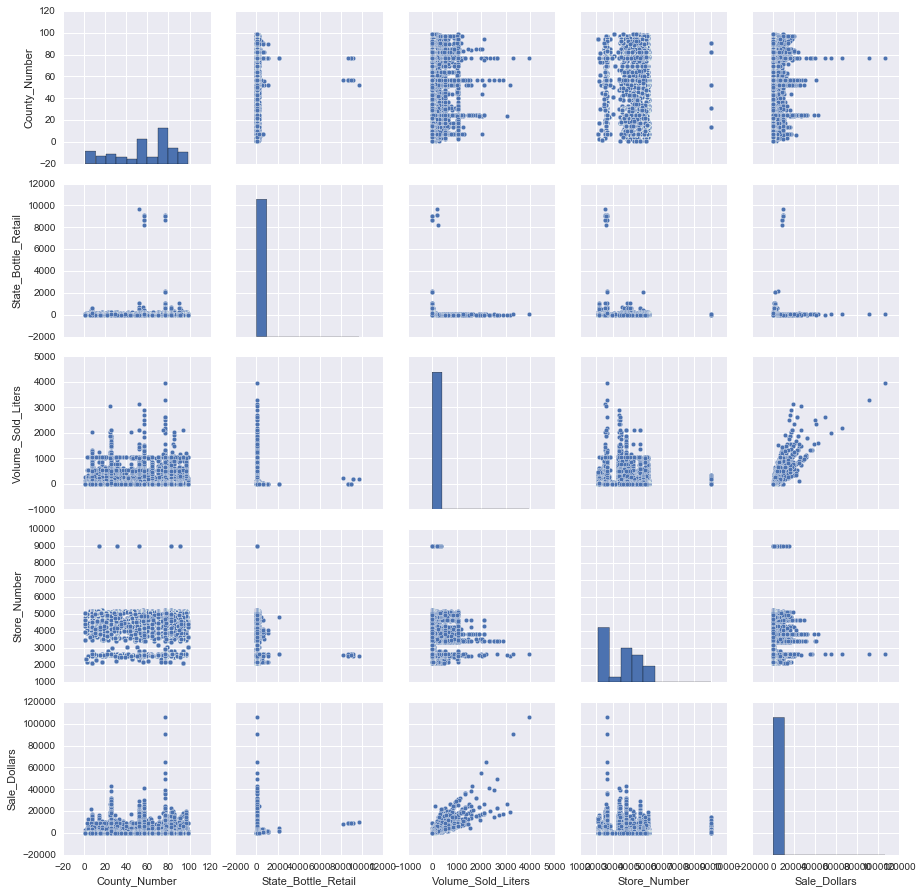

In [23]:
sns.pairplot(liquor[['County_Number','State_Bottle_Retail','Volume_Sold_Liters', 'Store_Number', 'Sale_Dollars']])

*From above it looks like there is relatively strong correlation between volume sold and sale_dollars, however it does seem like there is a high degree of heteroscedasticity.
Also looks like there may be a 'test' store number in the 9000 range that will have to be looked at and removed if that is the case*

In [25]:
liquor[liquor['Store_Number']>8000]

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons,Purchase_Margins
31943,03/28/2016,9013,Cumming,50061,91.0,Warren,1031080.0,VODKA 80 PROOF,154,38046,Swell Zone Vodka,750,11.49,17.24,24,413.76,18.0,4.76,138.00
39310,03/25/2016,9001,SWISHER,52338,52.0,Johnson,1011100.0,BLENDED WHISKIES,125,27632,Cedar Ridge Short's Whiskey,750,13.83,20.75,18,373.50,13.5,3.57,124.56
39311,03/25/2016,9001,SWISHER,52338,52.0,Johnson,1012300.0,IRISH WHISKIES,125,27476,Cedar Ridge Single Malt Whiskey,750,25.00,37.50,30,1125.00,22.5,5.94,375.00
39312,03/25/2016,9001,SWISHER,52338,52.0,Johnson,1011200.0,STRAIGHT BOURBON WHISKIES,125,27014,Cedar Ridge Malted Rye,750,19.67,29.51,30,885.30,22.5,5.94,295.20
39313,03/25/2016,9001,SWISHER,52338,52.0,Johnson,1011200.0,STRAIGHT BOURBON WHISKIES,125,17206,Cedar Ridge Bourbon,750,18.10,27.15,30,814.50,22.5,5.94,271.50
53012,03/23/2016,9013,Cumming,50061,91.0,Warren,1081700.0,DISTILLED SPIRITS SPECIALTY,226,75898,maDIKwe,750,11.59,17.39,12,208.68,9.0,2.38,69.60
124931,03/10/2016,9002,LECLAIRE,52753,82.0,Scott,1011100.0,BLENDED WHISKIES,306,27289,Iowish Whiskey,750,19.17,28.76,72,2070.72,54.0,14.27,690.48
126736,03/10/2016,9002,LECLAIRE,52753,82.0,Scott,1011100.0,BLENDED WHISKIES,306,27535,Queen Bee Honey Whiskey,375,9.09,13.64,12,163.68,4.5,1.19,54.60
126759,03/10/2016,9002,LECLAIRE,52753,82.0,Scott,1081900.0,MISC. AMERICAN CORDIALS & LIQUEURS,306,71902,Annie's Apple Pie,375,9.00,13.50,120,1620.00,45.0,11.89,540.00
126804,03/10/2016,9002,LECLAIRE,52753,82.0,Scott,1011200.0,STRAIGHT BOURBON WHISKIES,306,27479,Cody Road Bourbon,750,19.17,28.76,12,345.12,9.0,2.38,115.08


*The stores in the 9000 range are not test values and are operating stores.*

In [24]:
liquor['Purchase_Margins'] = liquor['Sale_Dollars']-liquor['State_Bottle_Cost'] * liquor['Bottles_Sold']

In [ ]:
plt.scatter(data=liquor_test, x='State_Bottle_Retail', y= "Purchase_Margins")


plt.xlabel("Retail Cost ($)")
plt.ylabel("Margins ($)")
plt.xlim(0, 400)
plt.ylim(0, 100)

In [ ]:
sns.pairplot(liquor_test[['State_Bottle_Retail','State_Bottle_Cost', 'Proportional Margins']])

In [ ]:
liquor_test[liquor_test['Proportional Margins'] > 0].describe()

In [ ]:
new_liq_test = liquor_test.sort(['County', 'Sale_Dollars']).groupby(['County', 'Store_Number']).sum()

In [ ]:
new_liq_test.head(2)

In [ ]:
new_liq_test.sort(['Sale_Dollars'], ascending = False)